In [18]:
import rasterio
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import seaborn as sns
import csv
import h5py

import fiona
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
from rasterio import windows as win
from statsmodels.formula.api import ols

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics

import io
from scipy import misc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [19]:
dfTemp=pd.read_csv(r'G:\NationalLayer\ClimateData\DailySummary\StationNeighborhood2016.csv')
dfTemp=dfTemp.loc[dfTemp.TempMax>0]

# 2011

In [238]:
# set the year
year = 2011
# set the address of nlcd products here
nlcd_tc_Address=r'G:\NationalLayer\NLCD_Products\2011\nlcd_2011_treecanopy_2019_08_31\nlcd_2011_treecanopy_2019_08_31_Projected.img'
nlcd_lc_Address=r'G:\NationalLayer\NLCD_Products\2011\nlcd_2011_landcover_2011_edition_2014_10_10\nlcd_2011_landcover_2011_edition_2014_10_10\nlcd_2011_landcover_2011_edition_2014_10_10_projected.img'
nlcd_imp_address=r'G:\NationalLayer\NLCD_Products\2011\nlcd_2011_impervious_2011_edition_2014_10_10\NLCD_Impervious_Projected\Impervious_Projected.img'
nlud_Address= r'G:\NationalLayer\NationalLandUse_0140326\nlud2010_Projected.img'

# set the address of surface temp hdf file
# key is 'ST'
stAddress=r'G:\NationalLayer\ST\st_stacked.hdf5'


# set the address of buiilding datasets
bldgSumAddress=r'G:\NationalLayer\US_Buildings\Conterminous_US_Building_Total_Area\bldgSum.img'



# set the ecosystem accounting area address here
ecoAcAreasShapefile=r'G:\NationalLayer\Census\UrbanAreas\nhgis0054_shape_Places_2010_withPop_hsng\US_place_2010_Projected_50k_pop.shp' 
ecoAcAreasRaster=r'G:\NationalLayer\Census\UrbanAreas\nhgis0054_shape_Places_2010_withPop_hsng\Places_50k_30m_raster.img'


# set the fields to get name and IDs
nameField='NAMELSAD10'
id_field='Pl_Uniq_id'

# 2016

In [20]:
# set the year
year = 2016
# set the address of nlcd products here
nlcd_tc_Address=r'G:\NationalLayer\NLCD_Products\2016\nlcd_2016_treecanopy_2019_08_31\nlcd_2016_treecanopy_2019_08_31_projected.img'
nlcd_lc_Address=r'G:\NationalLayer\NLCD_Products\2016\NLCD_2016_Land_Cover_L48_20190424\NLCD_2016_Land_Cover_L48_20190424_projected.img'
nlcd_imp_address=r'G:\NationalLayer\NLCD_Products\2011\nlcd_2011_impervious_2011_edition_2014_10_10\NLCD_Impervious_Projected\Impervious_Projected.img'
nlud_Address= r'G:\NationalLayer\NationalLandUse_0140326\nlud2010_Projected.img'

# set the address of surface temp hdf file
# key is 'ST'
stAddress=r'G:\NationalLayer\ST\st_stacked.hdf5'


# set the address of buiilding datasets
bldgSumAddress=r'G:\NationalLayer\US_Buildings\Conterminous_US_Building_Total_Area\bldgSum.img'



# set the ecosystem accounting area address here
ecoAcAreasShapefile=r'G:\NationalLayer\Census\UrbanAreas\nhgis0054_shape_Places_2010_withPop_hsng\US_place_2010_Projected_50k_pop.shp' 
ecoAcAreasRaster=r'G:\NationalLayer\Census\UrbanAreas\nhgis0054_shape_Places_2010_withPop_hsng\Places_50k_30m_raster.img'


# set the fields to get name and IDs
nameField='NAMELSAD10'
id_field='Pl_Uniq_id'

In [21]:
# get the list of codes and the list of names
lcCodes=[0,11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90, 95]
lcNames=['','Open Water','Perennial Ice/Snow','Developed Open Sapce','Developed Low Intensity',
         'Developed Medium Intensity','Developed High Intensity','Barren Land','Deciduous Forest','Evergreen Forest',
         'Mixed Forest','Dwarf','Shrub','Grassland','Sedge/Herb','Lichens','Moss','Pasture/hay','Cultivated Crops',
        'Woody Wetlands','Emergent Herbaceous Wetlands'
        ]
# get the list of codes and the list of names
LUcodes=[0,111,112,113,121,131,132,141,151,161,171,172,211,212,213,214,215,
       221,222,223,231,233,234,241,242,243,244,245,246,249,251,252,255,
       261,310,311,312,313,314,315,321,330,341,342,410,411,412,413,415,
       417,418,419,421,422,423,511,512,513,514,515,516,517,518,
       519,521,522,523,531,532
      ]

LUnames=['','Water Nat. Lake','Water Nat. Swamp/marsh','Water Nat. Playa','Water Hum. Reservoir','Water River',
      'Water Wash','Water Estuary','Water Canal/ditch','Water Wetlands','Water Open ocean','Water Bay/inlet',
       'BU Res. dense urba (>0.1 ac)','BU Res. Urban (0.1 - 1 ac)','BU Res. Suburban (1 - 2.5 ac)','BU Res. Exurban (2.5 - 10 ac)','BU Res. Rural (10 - 40 ac)',
       'BU Comm. Office','BU Comm. Retail/shopping','BU Comm. Entertainment','BU Ind. Factory, plant','BU Ind. Landfill waste trmt)',
       'BU Ind. Utilities','BU Inst. Schools (developed)','BU Inst. Schools (undeveloped)','BU Inst. Medical','BU Inst. Government/publicl',
       'BU Inst. Military (developed)','BU Inst. Military (undeveloped)','BU Inst. Prison','BU Trans. Airports','BU Trans. Highways/railways',
       'BU Trans. Undeveloped','BU Misc','Prod Cropland (general)','Prod Row crops','Prod Pastureland','Prod orchards','Prod sod & switchgrass',
       'Prod aquaculture','Prod Grazed','Prod Mining (open pit)','Prod Timber','Prod Timber plantations','Rec Dev. undifferentiated',
       'Rec Dev. Urban park','Rec Dev. Golf course','Rec Dev. Motorized','Rec Dev. Resort/Ski area','Rec Dev. Campground',
       'Rec Dev. Picnic area','Rec Dev. Boat/fish access','Rec. Nat. park','Rec. Nat. Recreation Area','Rec. Nat. Scenic Area',
       'Cons. Public Wildlife habitat','Cons. Public Conservation area','Cons. Public Nature Reserve','Cons. Public Wilderness',
       'Cons. Public ACEC/RNA','Cons. Public FWS Refuge','Cons. Public Wilderness study area','Cons. Public Archeaology, historic site',
       'Cons. Public Wild & Scenic River','Cons. Public-limited Municipal Watershed','Cons. Public-limited Corps Engineers',
       'Cons. Marine Protected Area','Cons. Private easement','Cons. Private ag easement'
      ]

# these are NAICS codes. We match the use type to NAICS codes 
dictNicsUses = {0:0,111:1,112:1,113:1,121:1,131:1,132:1,141:1,151:1,161:1,171:1,172:1,211:2,212:2,213:2,214:2,215:2,
       221:5,222:6,223:7,231:8,233:10,234:10,241:11,242:11,243:12,244:13,245:13,246:13,249:13,251:14,252:14,255:1,
       261:1,310:1,311:1,312:1,313:1,314:1,315:1,321:1,330:1,341:1,342:1,410:1,411:1,412:1,413:1,415:1,
       417:1,418:1,419:1,421:1,422:1,423:1,511:1,512:1,513:1,514:1,515:1,516:1,517:1,518:1,
       519:1,521:1,522:1,523:1,531:1,532:1 
               }
def creatDictionary (lstCodes,lstNames):
    dictNames={}
    for i in range(0,len(lstCodes)):
        dictNames[lstCodes[i]]=lstNames[i]
    return dictNames

# create a dictionary for landcover codes and names
dicLcCodes=creatDictionary(lcCodes,lcNames)
# create a dictionary for landuse codes and names
dicLuCodes = creatDictionary(LUcodes,LUnames)

def landCoverCodeConvert(codeNumb):
    return (dicLcCodes[codeNumb])

def landUseCodeConvert(codeNumb):
    return (dicLuCodes[codeNumb])

# this fucntion converts use types to NAICS Codes
def landuseToNAIOCS(useNumber):
    return (dictNicsUses[useNumber])

In [22]:
def nameCodeCol (dfArg,codeCol,nameCol,dictCodeNames):
    dfArg[nameCol]=''
    lstUniques=(dfArg[codeCol]).unique()
    for code in lstUniques:
        dfArg.loc[(dfArg[codeCol]==code),nameCol]=dictCodeNames[code]

In [23]:
def findWindow (shapeBound,mainRasterBnd,mainRasterCellSize):
    startRow = int((mainRasterBnd[3] - shapeBound[3])/mainRasterCellSize)
    endRow   = int((shapeBound[3] - shapeBound[1])/mainRasterCellSize)+1+startRow
    startCol = int((shapeBound[0] - mainRasterBnd[0])/mainRasterCellSize)
    endCol   = int((shapeBound[2] - shapeBound[0])/mainRasterCellSize)+1+startCol
    return (startRow,endRow,startCol,endCol)

In [24]:
# the $ cost of electicity per Kwh
dictElectricityPrice = {'AL' : 0.127,'AZ' : 0.122,'AR' : 0.093,'CA' : 0.198,'CO' : 0.120,'CT' : 0.227,'DE' : 0.121,'DC' : 0.130,'FL' : 0.119,'GA' : 0.108,'ID' : 0.095,
'IL' : 0.125,'IN' : 0.120,'IA' : 0.116,'KS' : 0.126,'KY' : 0.103,'LA' : 0.092,'ME' : 0.117,'MD' : 0.134,'MA' : 0.233,'MI' : 0.151,'MN' : 0.125, 'MS' : 0.112,'MO' : 0.091,
'MT' : 0.107,'NE' : 0.095,'NV' : 0.118,'NH' : 0.202,'NJ' : 0.162,'NM' : 0.126,'NY' : 0.176,'NC' : 0.117,'ND' : 0.090, 'OH' : 0.119,'OK' : 0.095,
'OR' : 0.108,'PA' : 0.136,'RI' : 0.242,'SC' : 0.127,'SD' : 0.105,'TN' : 0.107,'TX' : 0.117,'UT' : 0.101,'VA' : 0.115, 'WA' : 0.094,'WV' : 0.100,'WI' : 0.142,'WY' : 0.106}

In [25]:
with rasterio.open(nlcd_tc_Address) as rst_nlcd_tc:
            kwds = rst_nlcd_tc.meta.copy()
            mainRasterBnd=rst_nlcd_tc.bounds
            cellSize= kwds['transform'][0]

In [26]:
cellSize

30.0

In [27]:
dfTemp.sample(3)

,StationFID,TempMin,TempMax,Precip,windDirectionLetter,windSpped_Ave,evaporation,Station_ID,Ycoor,Xcoor,...,col9,col10,StationFID.1,XYcoorM,tc,water,imp,barren,st,bldgSum
4331,53094,9.169355,26.500000,24.6,NaN,NaN,75.032258,USC00457941,47.6811,-117.6267,...,NaN,NaN,53094,"(-1621440.8914594348, 2928584.052419699)",1.736393,0.000000,1.744412,0.022277,44.465629,0.492609
905,37099,12.135714,31.255357,28.6,NaN,NaN,NaN,USC00104318,43.6058,-116.9211,...,NaN,NaN,37099,"(-1668003.0837569917, 2475008.703244323)",0.371773,12.541769,1.316750,0.044553,41.651129,2.116118
1616,40672,13.524194,28.846774,108.6,NaN,NaN,NaN,USC00194131,42.3356,-73.2506,...,NaN,NaN,40672,"(1844668.2175152914, 2370507.7888065614)",10.624688,0.913344,2.842504,13.766986,34.618862,1.977735


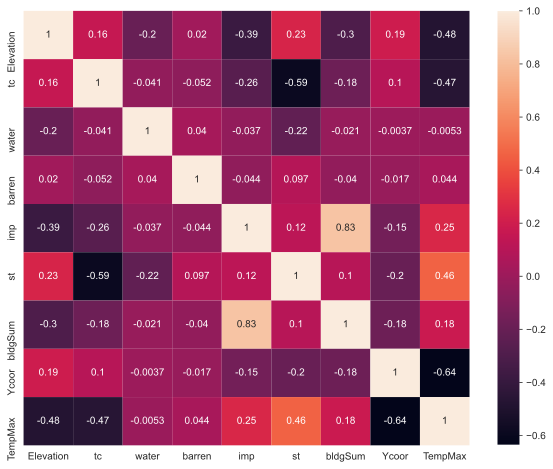

In [28]:
sns.set_style("whitegrid")

plt.figure(figsize=(10,8))

sns.heatmap(((dfTemp[['Elevation','tc','water','barren','imp','st','bldgSum','Ycoor','TempMax']]).corr()), annot=True)

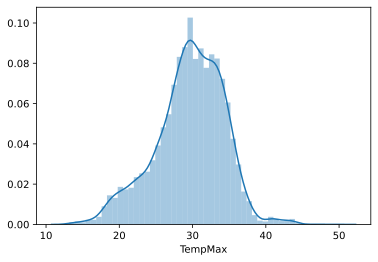

In [247]:
sns.distplot(dfTemp.TempMax)

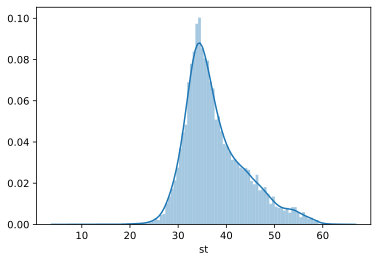

In [248]:
sns.distplot(dfTemp.st,bins=100)

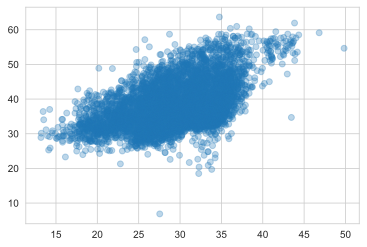

In [12]:
sns.set_style("whitegrid")

plt.scatter(dfTemp['TempMax'],dfTemp['st'],alpha=0.3)

In [29]:
(dfTemp[['TempMax','st','tc']]).corr()

,TempMax,st,tc
TempMax,1.000000,0.459689,-0.466695
st,0.459689,1.000000,-0.587169
tc,-0.466695,-0.587169,1.000000


# Model 2: Estimates Air Temperature. It uses weather station air temp as the dependent var and ST as independent var.

#### Model 2: Statmodel version

In [30]:
features_airModel = ['st','bldgSum','Ycoor']
depVar_airModel = dfTemp['TempMax']
indepVar_airModel = sm.add_constant(dfTemp[features_airModel],has_constant='add')
# Fit and summarize OLS model
airModel = sm.OLS(depVar_airModel, indepVar_airModel)
results_airModel = airModel.fit()
print(results_airModel.summary())
## for prediction the following code will be used:
predict_airModel = results_airModel.get_prediction(indepVar_airModel)
predict_airModel = predict_airModel.summary_frame(alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:                TempMax   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     2380.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        10:53:52   Log-Likelihood:                -16899.
No. Observations:                6510   AIC:                         3.381e+04
Df Residuals:                    6506   BIC:                         3.383e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.3234      0.444     90.780      0.0

<img src="image/Uncertanity_General_Rule.JPG" width=600 height=600 />

# Model 1: Estimates Surface Temperature. Then the estimated ST will be used as an input in the second model.

In [200]:
year

2016

In [32]:
lstDFsLandcover=[]
lstDFsLanduse=[]
lstCityInfo=[]
lstCityError=[]

# denver is 265
# NYC is 571
# Seattle is 215
for pol in fiona.open(ecoAcAreasShapefile)[480:481]:
    #try:
    #for pol in fiona.open(ecoAcAreasShapefile):
    eaa_name=(pol['properties'][nameField])
    eaa_state=(pol['properties'])['StateName']
    GISjoins=(pol['properties']['GISJOIN'])
    eaa_id=(pol['properties'][id_field])
    # kbtu per sq feet for residential use per year
    kbtu=(pol['properties']['KBTU'])
    poly_Ycoor=(pol['properties']['Y_coor'])
    poly=(shape(pol['geometry']))
    #msaPoly=[shape(pol['geometry']) for pol in fiona.open(masShapeAddress)]


    with rasterio.open(nlcd_tc_Address) as rst_nlcd_tc:
        kwds = rst_nlcd_tc.meta.copy()
        mainRasterBnd=rst_nlcd_tc.bounds
        cellSize= kwds['transform'][0]

    polyBound = poly.bounds

    # create a window parameter tuple.   
    winProcessing=findWindow(polyBound,mainRasterBnd,cellSize)
    #(row_start, row_stop), (col_start, col_stop)
    window_use=((winProcessing[0],winProcessing[1]),(winProcessing[2],winProcessing[3]))

    # set the cells that do not have the city id as np.nan. This way we are getting cells insdie the boundary only.
    with rasterio.open(ecoAcAreasRaster) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNodata=src.nodata
        arrayShapes=eaaAr.shape
        eaaAr=eaaAr.flatten()

    #when running high resolution layers for a snigle city use the following block instead of nlcd-tc block
#     addressHighResCity = r'D:\temp\UrbanEA_HighRes\NYC_tree_Cover.img'
#     with rasterio.open(addressHighResCity) as rsc:
#         kwdsHighResCity = rsc.meta.copy()
#         HighResBound=rsc.bounds
#         HighResNoData=kwdsHighResCity['nodata']
#         cellSizeHighRes= kwdsHighResCity['transform'][0]
#         HighResWindow = findWindow(polyBound, HighResBound,cellSizeHighRes)
#         HighResWindow_use=((HighResWindow[0],HighResWindow[1]),(HighResWindow[2],HighResWindow[3]))
#         HighResCityAr=rsc.read(1, window=HighResWindow_use)
#         HighResCityAr=HighResCityAr.astype('float')
#         nlcd_tc_win_ar = HighResCityAr.flatten()
#         nlcd_tc_nodata = rsc.nodata

    #when running the national scale, the previous block should be commented and this block should be uncommented
    with rasterio.open(nlcd_tc_Address) as rst_nlcd_tc:
        nlcd_tc_win_ar=rst_nlcd_tc.read(1, window=window_use)
        nlcd_tc_nodata=rst_nlcd_tc.nodata
        nlcd_tc_win_ar=nlcd_tc_win_ar.astype('float')
        #nlcd_tc_win_ar[eaaAr!=eaa_id]=np.nan
        nlcd_tc_win_ar=nlcd_tc_win_ar.flatten()
        kwds = rst_nlcd_tc.meta.copy()

    with rasterio.open(nlcd_lc_Address) as src:
        nlcd_lc=src.read(1, window=window_use)
        nlcd_lc_nodata=src.nodata
        nlcd_lc=nlcd_lc.astype('float')
        #nlcd_lc[eaaAr!=eaa_id]=np.nan
        nlcd_lc=nlcd_lc.flatten()
    #print('got the nlcd-lc layer')

    with rasterio.open(nlcd_imp_address) as src:
        nlcd_imp=src.read(1, window=window_use)
        nlcd_imp_nodata=src.nodata
        nlcd_imp=nlcd_imp.astype('float')
        #nlcd_imp[eaaAr!=eaa_id]=np.nan
        nlcd_imp=nlcd_imp.flatten()


    with rasterio.open(bldgSumAddress) as src:
        bldgSum=src.read(1, window=window_use)
        bldgSumNodata=src.nodata
        # bldgSum=(bldgSum.astype('float')/9)
        #bldgSum[eaaAr!=eaa_id]=np.nan
        bldgSum=bldgSum.flatten()

    with h5py.File(stAddress,'r') as src:
        sTemp=src['ST'][(window_use[0][0]):(window_use[0][1]),(window_use[1][0]):(window_use[1][1])]
        sTemp=(sTemp.astype('float'))/100
        #sTemp[eaaAr!=eaa_id]=np.nan
        sTemp=sTemp.flatten()


    with rasterio.open(nlud_Address) as src:
        nlud=src.read(1, window=window_use)
        nlud_nodata=src.nodata
        nlud=nlud.astype('float')
        #nlud[eaaAr!=eaa_id]=np.nan
        nlud=nlud.flatten()



    allArrays=np.dstack((nlcd_tc_win_ar,nlcd_lc,nlud,sTemp,bldgSum,
                         eaaAr,nlcd_imp))
    allArrays=allArrays[0,:,:]

    df=pd.DataFrame(allArrays,columns=['TC','LC','LU','ST','bldgSum',
                                       'eaaAr','imp'])

    # some filtering is needed
    df=df[((df['TC']!=nlcd_tc_nodata)&
          (df['LC']!=nlcd_lc_nodata)&
          (df['ST']>=0)&
          (df['ST']<=70)&
          (df['bldgSum']!=bldgSumNodata)&
          (df['LC']!=11)&
          (df['LC']!=nlcd_lc_nodata))
         ]

    df['bldgSum'] = (df['bldgSum'].astype('float'))/9


    # assign the Y coordinate of the city (decimal degree)
    df['Ycoor'] = poly_Ycoor
    # Change the name of the cols of land use and land cover



    features_stModel=['TC','imp']
    depVar_stModel = df['ST']
    indepVar_stModel = sm.add_constant(df[features_stModel],has_constant='add')
    # Fit and summarize OLS model
    st_model = sm.OLS(depVar_stModel, indepVar_stModel)
    results_stModel = st_model.fit()
    #print(results_stModel.summary())
    pred_st_model = results_stModel.get_prediction(indepVar_stModel)
    pred_df_st_model = pred_st_model.summary_frame()

    # we need to fist add the estimated st as the model output to the dataframe. 
    df['estimated_st'] = pred_df_st_model['mean']
    df['error_st'] = (np.abs(pred_df_st_model['obs_ci_upper']-pred_df_st_model['obs_ci_lower']))/2.0


    # Now we want to know what would be the model when tree cover is 0. We will have a new estimation.

    indepVar_TC0=indepVar_stModel.copy()
    indepVar_TC0['TC']=0
    pred_st_t0 = results_stModel.get_prediction(indepVar_TC0)
    pred_st_t0 = pred_st_t0.summary_frame()
    # here we get the predicted values and its error using observed confidence interval lower
    df['estimated_st_TC0'] = pred_st_t0['mean']
    df['error_st_TC0'] = (np.abs(pred_st_t0['obs_ci_upper']-pred_st_t0['obs_ci_lower']))/2.0


    # now we use the estimated STs (with TC and with TC0) to estimate Air Temp using the model 2
    # build the independent variables of the air model using the dataframe of the city
    features_airModel_city = ['estimated_st','bldgSum','Ycoor']
    indepVar_airModel_city = sm.add_constant(df[features_airModel_city],has_constant='add')
    # for prediction the following code will be used:
    predict_airModel_city = results_airModel.get_prediction(indepVar_airModel_city)
    predict_airModel_city = predict_airModel_city.summary_frame(alpha=0.05)
    # now write them in the df
    df['estimated_air_temp'] = predict_airModel_city['mean']
    df['error_air_temp'] = (np.abs(predict_airModel_city['obs_ci_upper']-predict_airModel_city['obs_ci_lower']))/2.0

    # now we predict air temperature with TC0
    features_airModel_city_stOfTC0 = ['estimated_st_TC0','bldgSum','Ycoor']
    indepVar_airModel_city_stOfTC0 = sm.add_constant(df[features_airModel_city_stOfTC0],has_constant='add')
    # now put the independent variables in the model
    predict_airModel_city_TC0 = results_airModel.get_prediction(indepVar_airModel_city_stOfTC0)
    predict_airModel_city_TC0 = predict_airModel_city_TC0.summary_frame(alpha=0.05)
    # now write them in the df
    df['estimated_air_temp_TC0'] = predict_airModel_city_TC0['mean']
    df['error_air_temp_TC0'] = (np.abs(predict_airModel_city_TC0['obs_ci_upper']-predict_airModel_city_TC0['obs_ci_lower']))/2.0

    # now heat mitigation impact 
    df['cooling'] = df['estimated_air_temp_TC0']-df['estimated_air_temp']
    # calculating the propagated error using fractional error equation
    df['overall_fractional_error']=(np.sqrt((np.square(df['error_st']/df['estimated_st']))+
                                             (np.square(df['error_st_TC0']/df['estimated_st_TC0']))+
                                             (np.square(df['error_air_temp']/df['estimated_air_temp'])) + 
                                             (np.square(df['error_air_temp_TC0']/df['estimated_air_temp_TC0']))
                                            )) * df['cooling']
    # now calculate upper bound and lower bound
    df['upper_cooling'] = df['cooling'] + (df['cooling']*df['overall_fractional_error'])
    df['lower_cooling'] = df['cooling'] - (df['cooling']*df['overall_fractional_error']) 

    df.loc[(df['TC']==0),'cooling']=0
    df.loc[(df['TC']==0),'upper_cooling']=0
    df.loc[(df['TC']==0),'lower_cooling']=0


    df.loc[((df['estimated_air_temp']<=19)&(df['estimated_air_temp_TC0']<=19)),'cooling']= 0
    df.loc[((df['estimated_air_temp']<=19)&(df['estimated_air_temp_TC0']<=19)),'upper_cooling']= 0
    df.loc[((df['estimated_air_temp']<=19)&(df['estimated_air_temp_TC0']<=19)),'lower_cooling']= 0

    # convet percent building to sqm (9) and then sqm to sqft (10.76) and then convert to Kwh (2.9307106944) * state_electricity_price
    df['EnergyValue']=      (((df['cooling'])/0.5)*0.02) * kbtu * df['bldgSum']*9*10.7639*0.29307106944*dictElectricityPrice[eaa_state] # this is the $ value
    df['EnergyValue_upper']=(((df['upper_cooling'])/0.5)*0.02) *kbtu*df['bldgSum']*9*10.7639*0.29307106944*dictElectricityPrice[eaa_state] # this is the $ value
    df['EnergyValue_lower']=(((df['lower_cooling'])/0.5)*0.02) *kbtu*df['bldgSum']*9*10.7639*0.29307106944*dictElectricityPrice[eaa_state] # this is the $ value

    df=df[df['eaaAr']==eaa_id]

    dfAgrLandcover=df.groupby(['LC']).agg({'EnergyValue': ['sum'],'EnergyValue_upper': ['sum'],'EnergyValue_lower': ['sum']})
    dfAgrLanduse  =df.groupby(['LU']).agg({'EnergyValue': ['sum'],'EnergyValue_upper': ['sum'],'EnergyValue_lower': ['sum']})
    dfAgrLandcover.columns = dfAgrLandcover.columns.droplevel(1)
    dfAgrLanduse.columns = dfAgrLanduse.columns.droplevel(1)

    dfAgrLandcover['eaa_name']=eaa_name
    dfAgrLandcover['eaa_id']=eaa_id
    dfAgrLandcover['GISjoins']=GISjoins
    dfAgrLandcover['State'] = eaa_state
    dfAgrLandcover['StateCost']= dictElectricityPrice[eaa_state]

    dfAgrLanduse['eaa_name']=eaa_name
    dfAgrLanduse['eaa_id']=eaa_id
    dfAgrLanduse['GISjoins']=GISjoins
    dfAgrLanduse['State'] = eaa_state
    dfAgrLanduse['StateCost']= dictElectricityPrice[eaa_state]

    lstCityInfo.append([eaa_name,eaa_state,GISjoins,eaa_id,results_stModel.rsquared_adj,results_airModel.rsquared_adj,
                        df['EnergyValue'].sum(),df['EnergyValue_upper'].sum(),df['EnergyValue_lower'].sum(),results_stModel.params[1],dictElectricityPrice[eaa_state]])

    lstDFsLandcover.append(dfAgrLandcover)
    lstDFsLanduse.append(dfAgrLanduse)
    print('we finished working on {}'.format(eaa_name))
    #except:
        #lstCityError.append(eaa_name)


we finished working on Cambridge city


In [235]:
nlcd_tc_win_ar.shape

(2366268,)

### only inside city cellls linear

In [228]:
year

2016

In [258]:
dfCityResult = pd.DataFrame(lstCityInfo, columns=['eaa_name','State','GISjoins','eaa_id','stModel_R2','airModel_R2','EnergySavings','EnergySavings_upper','EnergySavings_lower','tc_parameter_stModel','StateCost'])
allDfsLandcover = pd.concat(lstDFsLandcover)
allDfsLandcover['LC']=(allDfsLandcover.index).astype('int16')
allDfsLanduse   = pd.concat(lstDFsLanduse)
allDfsLanduse['LU']=(allDfsLanduse.index).astype('int16')

In [259]:
nameCodeCol(allDfsLandcover,'LC','LC_name',dicLcCodes)
nameCodeCol(allDfsLanduse,'LU','NAICS' ,dictNicsUses)
nameCodeCol(allDfsLanduse,'LU','LU_name',dicLuCodes)

In [260]:
citiesWithNull = (dfCityResult[dfCityResult['EnergySavings']<=0]).eaa_name.unique()
dfCityResult = dfCityResult.loc[~(dfCityResult['eaa_name'].isin(citiesWithNull))]
allDfsLandcover = allDfsLandcover.loc[~(allDfsLandcover['eaa_name'].isin(citiesWithNull))]
allDfsLanduse = allDfsLanduse.loc[~(allDfsLanduse['eaa_name'].isin(citiesWithNull))]

In [261]:
folderAddress = r'D:\OneDriveSyncFolder\OneDrive - The University of Colorado Denver\Ecosystem Service Accounting Project\Papers\Urban EA\Results\2020Version\Heat\HighResolutionForSensitivity'
dfCityResult.to_csv(folderAddress +    r'\NYC_NLCD_Heat_ModelSummary2016.csv')
allDfsLandcover.to_csv(folderAddress + r'\NYC_NLCD_Heat_allDfsLandcover2016.csv')
allDfsLanduse.to_csv(folderAddress +   r'\NYC_NLCD_Heat_allDfsLanduse2016.csv')

In [130]:
dfCityResult

,eaa_name,State,GISjoins,eaa_id,stModel_R2,airModel_R2,EnergySavings,EnergySavings_upper,EnergySavings_lower,tc_parameter_stModel,StateCost
0,Seattle city,WA,G5363000,216,0.435003,0.522973,4.634252e+06,5.040974e+06,4.227529e+06,-0.025874,0.094
